In [1]:
!pip install opencv-python 

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/77/df/b56175c3fb5bc058774bdcf35f5a71cf9c3c5b909f98a1c688eb71cd3b1f/opencv_python-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 78.4 kB/s eta 0:00:0000:01m0:09m


In [2]:
import os
from glob import glob
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

In [45]:
src_path = "/Users/ar.galanin/Documents/coding/DataScience/image_quality"  # Здесь укажите путь до вашей папки (локальной, если вы работаете локально или на гугл диске, если в colab (см гайд))
path_2_train_csv = os.path.join(src_path, 'train.csv')
train_df = pd.read_csv('train.csv')

In [4]:
train_df

,img_name,PSNR
0,100083_1.png,29.543164
1,100083_2.png,27.894582
2,100083_3.png,29.350353
3,100083_4.png,27.775248
4,100083_5.png,34.358442
...,...,...
13205,99961_1.png,28.265920
13206,99961_2.png,27.889166
13207,99961_3.png,27.856139
13208,99961_4.png,29.720789


In [46]:
# загружае изображения и сохраняем их в список
imgs = []
for img_name in tqdm(train_df.img_name.values, total=len(train_df)):
    img = cv2.imread(os.path.join(src_path, 'train', img_name))
    imgs.append(img)

  0%|          | 0/13210 [00:00<?, ?it/s]

In [47]:
path_2_test_csv = os.path.join(src_path, 'sample_submission.csv') # В sample_submission хранятся имена файлов тестовой выборки
test_df = pd.read_csv(path_2_test_csv)

In [48]:
# Загрузка тестовой выборки
test_imgs = []
for img_name in tqdm(test_df.img_name.values, total=len(test_df)):
    img = cv2.imread(os.path.join(src_path, 'test', img_name))
    test_imgs.append(img)

  0%|          | 0/3310 [00:00<?, ?it/s]

In [69]:
len(imgs)

13210

In [49]:
imgs = np.array(imgs)

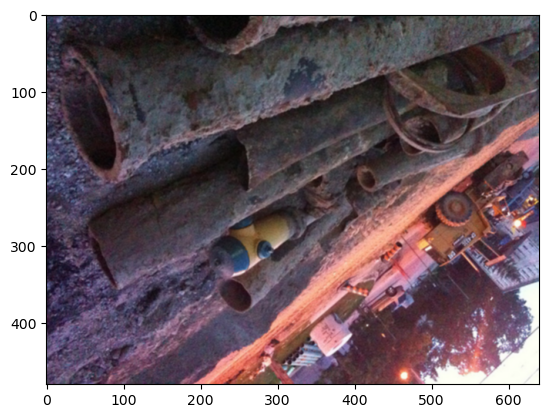

In [10]:
# Посмотрим пример картинки из датасета, который мы загрузили
ind = np.random.randint(0, len(imgs))
plt.imshow(cv2.cvtColor(imgs[ind], cv2.COLOR_BGR2RGB))
plt.show()

In [50]:
# извлекаем уникальные идентификаторы изображений
ref_names = set()
for img_name in train_df.img_name.values:
    ref_names.add(img_name.split('_')[0])
ref_names = sorted(list(ref_names))
random.seed(7)
random.shuffle(ref_names)

In [12]:
ref_names

['168246',
 '12238',
 '477288',
 '46252',
 '25743',
 '184295',
 '20925',
 '258023',
 '290432',
 '531134',
 '50355',
 '302603',
 '510992',
 '495456',
 '85529',
 '317028',
 '188824',
 '522778',
 '533378',
 '578713',
 '499480',
 '156533',
 '49731',
 '378545',
 '520982',
 '334015',
 '189193',
 '190907',
 '335844',
 '399058',
 '577640',
 '535579',
 '186130',
 '31269',
 '236123',
 '475710',
 '212322',
 '327323',
 '282298',
 '11796',
 '227187',
 '302997',
 '394206',
 '451944',
 '250167',
 '458549',
 '144228',
 '177811',
 '406253',
 '350003',
 '9628',
 '22724',
 '307773',
 '474667',
 '561116',
 '487295',
 '82174',
 '206300',
 '494456',
 '156915',
 '365822',
 '491653',
 '536947',
 '449726',
 '223959',
 '154670',
 '126941',
 '212453',
 '17667',
 '315062',
 '520659',
 '522127',
 '439961',
 '433822',
 '437618',
 '335132',
 '13081',
 '445009',
 '570826',
 '211386',
 '402313',
 '476299',
 '521721',
 '535183',
 '162130',
 '288923',
 '296072',
 '434897',
 '50331',
 '67959',
 '508514',
 '542042',
 '393

In [51]:
# Деление на train и val
train_size = 0.8

train_names = []
train_ids = []
val_names = []
val_ids = []
for i, img_name in enumerate(train_df.img_name.values):
    ref = img_name.split('_')[0]
    if ref in ref_names[:int(train_size * len(ref_names))]:
        train_names.append(img_name)
        train_ids.append(i)
    else:
        val_names.append(img_name)
        val_ids.append(i)
print(f"Train size: {len(train_names)}")
print(f"Validation size: {len(val_names)}")

Train size: 10565
Validation size: 2645


In [52]:
tr_df = train_df.set_index('img_name').loc[train_names]
val_df = train_df.set_index('img_name').loc[val_names]

In [35]:
val_df

,PSNR
img_name,
100083_1.png,29.543164
100083_2.png,27.894582
100083_3.png,29.350353
100083_4.png,27.775248
100083_5.png,34.358442
...,...
98895_1.png,31.886758
98895_2.png,27.883133
98895_3.png,27.891997


In [53]:
def brightness(img): # Яркость
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v = hsv[..., 2].mean()
    return v / 255 # normalization

def sharpness_grad_based(img): # резкость
    gradx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
    grady = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
    grad = np.sqrt(gradx * gradx + grady * grady)
    return grad[1: -1, 1: -1].mean()

def contrast(img): # контрастность 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    contrast = gray.std()
    return contrast

def get_iqa_fv(img):
    fv = np.empty((0,))
    fv = np.append(fv, brightness(img))
    fv = np.append(fv, sharpness_grad_based(img))
    # ...your features here...
    fv = np.append(fv,contrast(img))
    return fv

def get_features(list_of_imgs):
    features =[]
    for img in tqdm(list_of_imgs):
        features.append(get_iqa_fv(img))
    features = np.vstack(list(features))
    return features

In [54]:
print('Подсчет признаков обучающей выборки...')
X_train = get_features(imgs[train_ids])
print('Подсчет признаков валидационной выборки...')
X_val = get_features(imgs[val_ids])
X_train.shape, X_val.shape

Подсчет признаков обучающей выборки...


  0%|          | 0/10565 [00:00<?, ?it/s]

Подсчет признаков валидационной выборки...


  0%|          | 0/2645 [00:00<?, ?it/s]

((10565, 3), (2645, 3))

In [55]:
y_train = tr_df.PSNR.values
y_val = val_df.PSNR.values

In [57]:
y_train

array([29.81100498, 27.89953137, 28.0290817 , ..., 27.8561391 ,
       29.72078868, 28.28530245])

In [64]:
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor

# обучение модели
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

In [65]:
# Введем метрики оценки качества модели
def mse(y_true, y_pred):
    return ((y_true - y_pred)**2).mean()
def mae(y_true, y_pred):
    return (np.abs(y_true - y_pred)).mean()

In [66]:
# Оценим нашу модель на валидационной выборке:
print(f"MSE = {mse(y_val, y_pred)} \nMAE = {mae(y_val, y_pred)}")

MSE = 2.938071369444021 
MAE = 0.927094397653971


In [67]:
# генерация фичей
print('Подсчет признаков тестовой выборки...')
X_test = get_features(test_imgs)



y_pred = model.predict(X_test)


Подсчет признаков тестовой выборки...


  0%|          | 0/3310 [00:00<?, ?it/s]

In [68]:
import pandas as pd

# Сохранение результатов
predictions = pd.DataFrame({'img_name': test_df.img_name.values, 'PSNR': y_pred})
predictions.to_csv("predict.csv", index=False)

In [69]:
from IPython import display

# Создание ссылки для скачивания файла
display.FileLink("predict.csv")

/Users/ar.galanin/Documents/coding/DataScience/image_quality/predict.csv